# Using Reddit's API for Classifying Subreddit Posts

In this project, we will practice two major skills. Collecting data via an API request and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to what subreddit it belongs to?_

Your method for acquiring the data will be scraping threads from at least two subreddits. 

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts which subreddit a given post belongs to.

In [91]:
# Library Imports

# Regular data cleaning/handling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
%matplotlib inline

# NLP specific libraries
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import stop_words
import re
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer



# Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

## Text Cleaning

In [92]:
# using regular expressions to remove punctuation in a function
def no_punct(string):
    return re.sub("[.,😯?😊!’\";^+`:*'()-@”“=>_$&<~%|{}\[\]]", " ", string)

In [93]:
# Create a function to clean any column or to feed into the CountVectorizer as analyzer parameter
def clean_func(column):
    
    #remove puntuation with punctuation removal function
    column = no_punct(column)
    
    #lowercase
    column = column.lower()
    
    #split string into just words
    #column = column.split()
    
    return column

In [94]:
# from the nlp lab

def preprocess(text):
    # instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # lowercase
    text = text.lower()
    
    # words only Regex, removes punctuation
    text = re.sub("[^A-Za-z]", " ", text)
    
    # lemmatize
    text = lemmatizer.lemmatize(text)
    
    # Take out stopwords
    #text = [x for x in text.split() if not x in stopwords.words('english')]
    
    return text

## Data cleaning and EDA

In [95]:
geo_df = pd.read_csv('./reddit_geocaching_posts.csv')

In [96]:
geo_df.head()

,text,title,subreddit
0,Can anyone advise me on how to log this multic...,Not sure how to log cache,geocaching
1,NaN,A quick Virtual Cache for the August Geochalle...,geocaching
2,I just bought a travel bug dog tag last week. ...,Copy Tag Question,geocaching
3,NaN,Logged my 300th find today! Atop Little Haysta...,geocaching
4,NaN,A neat set of mushrooms i saw on my caxhe hunt...,geocaching


In [97]:
geo_df.tail()

,text,title,subreddit
995,Is there a way to obtain a 30 day premium? My ...,30 day premium?,geocaching
996,NaN,Geocaching Adventure in North Texas!,geocaching
997,What to do with this cache/s? (Poll)\r\r\n\r\r...,What to do with this cache/s? (Poll),geocaching
998,I’m wondering if I’m over doing it with plasti...,Plastic Bags,geocaching
999,"I found my spot and confirmed it’s available, ...",Help: Hiding my first cache,geocaching


In [98]:
geo_df.describe().T

,count,unique,top,freq
text,475,474,"My mom and I have not ""found"" a cache with a 5...",2
title,1000,999,5 Terrain,2
subreddit,1000,1,geocaching,1000


In [99]:
# Need to drop a duplicate
geo_df.drop_duplicates(inplace=True)

In [100]:
# How many nulls?
geo_df.isnull().sum()

text         525
title          0
subreddit      0
dtype: int64

In [101]:
# Fill NaNs with NA
geo_df.fillna('NA', inplace=True)

In [102]:
geo_df.shape

(999, 3)

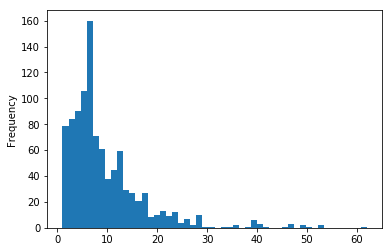

In [103]:
# Look at length of title
geo_title_length = geo_df['title'].map(clean_func)
geo_title_length = geo_title_length.str.split()
geo_title_length = geo_title_length.apply(len)

# Plot it, is it significant?
geo_title_length.plot(bins=50, kind='hist');

In [104]:
geo_title_length.describe().T

count    999.000000
mean       9.554555
std        8.033421
min        1.000000
25%        4.000000
50%        7.000000
75%       12.000000
max       62.000000
Name: title, dtype: float64

Mostly distributed under 10 words but really skewed with a long tail. So there are only a few titles that are really long.

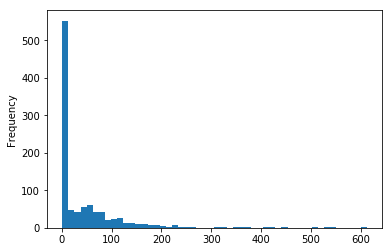

In [105]:
# Look at length of text
geo_text_length = geo_df['text'].map(clean_func)
geo_text_length = geo_text_length.str.split()
geo_text_length = geo_text_length.apply(len)

geo_text_length.plot(bins=50, kind='hist');

In [106]:
geo_text_length.describe().T

count    999.000000
mean      41.844845
std       70.957119
min        1.000000
25%        1.000000
50%        1.000000
75%       61.000000
max      612.000000
Name: text, dtype: float64

Many posts have no text, or very short text bodies. But there is a much more longer skew with the tail on the right. Since text bodies can be longer, there are a few posts that are even longer than the longest titles

## Bring in IWantToLearn data for cleaning and exploring

In [107]:
iwtl_df = pd.read_csv('./reddit_iwanttolearn_posts.csv')

In [108]:
iwtl_df.head()

,text,title,subreddit
0,Ever since I was young the thought of having t...,IWTL how to be okay with having to work for th...,IWantToLearn
1,In case my dominant hand is damaged.,IWTL how to be ambidexter.,IWantToLearn
2,NaN,I want to learn how to experience music instea...,IWantToLearn
3,"Hi guys, are there any good courses, games or ...",IWTL how to improve my logical thinking and pr...,IWantToLearn
4,"I have always wanted to own my own businesses,...",IWTL how to start a business - specifically a ...,IWantToLearn


In [109]:
iwtl_df.isnull().sum()

text         108
title          0
subreddit      0
dtype: int64

In [110]:
# Dropping duplicates, and fill NaNs
iwtl_df.drop_duplicates(inplace=True)
iwtl_df.fillna('NA', inplace=True)

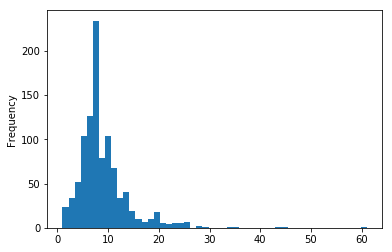

In [111]:
# Look at length of title
iwtl_title_length = iwtl_df['title'].map(clean_func)
iwtl_title_length = iwtl_title_length.str.split()
iwtl_title_length = iwtl_title_length.apply(len)

# Plot it, is it significant?
iwtl_title_length.plot(bins=50, kind='hist');

In [112]:
iwtl_title_length.describe()

count    996.000000
mean       8.823293
std        5.084502
min        1.000000
25%        6.000000
50%        8.000000
75%       10.000000
max       61.000000
Name: title, dtype: float64

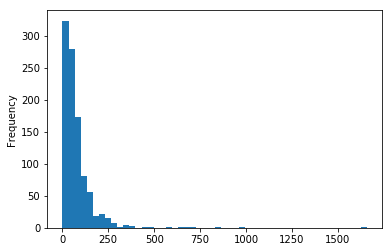

In [113]:
# Look at length of text
iwtl_text_length = iwtl_df['text'].map(clean_func)
iwtl_text_length = iwtl_text_length.str.split()
iwtl_text_length = iwtl_text_length.apply(len)

iwtl_text_length.plot(bins=50, kind='hist');

In [114]:
iwtl_text_length.describe()

count     996.000000
mean       75.657631
std        99.467357
min         1.000000
25%        27.000000
50%        54.000000
75%        92.000000
max      1657.000000
Name: text, dtype: float64

At a glance it looks like IWantToLearn titles and Geocaching titles are mostly distributed in less than 10 words. IWantToLearn posts have fewer "title only" type posts and tend to be longer than the geocaching posts that do have text.

In [115]:
# check that cleaning is correct
iwtl_df.head()

,text,title,subreddit
0,Ever since I was young the thought of having t...,IWTL how to be okay with having to work for th...,IWantToLearn
1,In case my dominant hand is damaged.,IWTL how to be ambidexter.,IWantToLearn
2,NA,I want to learn how to experience music instea...,IWantToLearn
3,"Hi guys, are there any good courses, games or ...",IWTL how to improve my logical thinking and pr...,IWantToLearn
4,"I have always wanted to own my own businesses,...",IWTL how to start a business - specifically a ...,IWantToLearn


## Creating Corpora

Keep title and post text separate and create models from each separately. Later, I will explore whether combining both title and post text make a significant difference.

In [195]:
# Create the corpus for titles
title_corpus = pd.concat([geo_df['title'], iwtl_df['title']], axis=0, ignore_index=True)
# type(title_corpus)

In [196]:
# Create the corpus for text
text_corpus = pd.concat([geo_df['text'], iwtl_df['text']], axis=0, ignore_index=True)
# type(text_corpus)

#### We want to predict a binary variable - class `0` for one of your subreddits and `1` for the other.

In [118]:
# Create the target column, change geocaching = 0, IWTL = 1
y = pd.concat([geo_df['subreddit'], iwtl_df['subreddit']], axis=0, ignore_index=True)
y = y.map({'geocaching': 0, 'IWantToLearn': 1})

In [194]:
text_corpus.tail()

1990    ​EDIT: Specifically signal processing, I'd lik...
1991    So that i have more money at the end of the mo...
1992    And overcome my fear of presenting in front of...
1993    Hello friends, today has been a very bad day f...
1994    A friend of mine dared me to go mad for 1 week...
Name: text, dtype: object

## NLP

#### Use `CountVectorizer` or `TfidfVectorizer` from scikit-learn to create features from the thread titles and descriptions (NOTE: Not all threads have a description)
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

### Master stopword list

In [119]:
# Create a master stopword list from both stopword lists
custom_stopwords = list(set(stopwords.words('english') + list(stop_words.ENGLISH_STOP_WORDS)))

# Add 'na' because it indicates an empty text post
custom_stopwords.extend(['na'])

In [120]:
len(custom_stopwords)

379

In [121]:
# Create a stopword list that only takes out 'na'
no_na = ['na']

## Count Vectorizer

In [176]:
# Instantiate CountVectorizer, leave as default but make sure 'na' isnt a feature
cvec = CountVectorizer(stop_words=no_na)

In [177]:
title_counts = cvec.fit_transform(title_corpus)

In [180]:
cvec.vocabulary_

{'not': 2201,
 'sure': 3075,
 'how': 1571,
 'to': 3224,
 'log': 1894,
 'cache': 504,
 'quick': 2560,
 'virtual': 3413,
 'for': 1262,
 'the': 3169,
 'august': 307,
 'geochallenge': 1354,
 'copy': 765,
 'tag': 3106,
 'question': 2558,
 'logged': 1898,
 'my': 2134,
 '300th': 44,
 'find': 1213,
 'today': 3226,
 'atop': 292,
 'little': 1876,
 'haystack': 1501,
 'nh': 2180,
 'neat': 2158,
 'set': 2805,
 'of': 2225,
 'mushrooms': 2129,
 'saw': 2738,
 'on': 2243,
 'caxhe': 561,
 'hunt': 1578,
 'this': 3190,
 'morning': 2098,
 'spring': 2969,
 'caching': 512,
 'carnival': 545,
 'geocaching': 1352,
 'australia': 309,
 'more': 2096,
 'in': 1630,
 'comments': 686,
 'so': 2913,
 'recently': 2606,
 'started': 2983,
 'new': 2174,
 'thing': 3184,
 'despite': 895,
 'rain': 2571,
 'falling': 1162,
 'hurting': 1581,
 'shoulder': 2836,
 'and': 197,
 'stabbing': 2974,
 'inside': 1670,
 'mouth': 2110,
 'because': 368,
 'was': 3451,
 'stupid': 3044,
 'enough': 1080,
 'fall': 1161,
 'face': 1154,
 'first': 12

In [181]:
counts = pd.DataFrame(title_counts.todense(), columns=cvec.vocabulary_)

In [183]:
counts.sum().sort_values(ascending=False)

light           1221
nnamdi           767
mgs              748
skilled          396
people           337
hooked           315
negative         277
affect           221
touches          187
apps             181
prague           158
ice              137
ci               135
makes            128
hand             123
glad             123
why              123
commitments      116
outside          112
meal             111
crisis           109
cheeseburger     104
ammo              94
gz                88
spot              87
bridge            79
form              75
national          72
15th              68
specifically      67
                ... 
revenge            1
impressively       1
seeing             1
reputation         1
gets               1
wall               1
dead               1
walking            1
jobs               1
litter             1
constructed        1
stealth            1
cam                1
gcae               1
hollow             1
late               1
lucille      

In [184]:
text_counts = cvec.fit_transform(text_corpus)

In [185]:
counts2 = pd.DataFrame(text_counts.todense(), columns=cvec.vocabulary_)

In [188]:
counts2

,can,anyone,advise,me,on,how,to,log,this,multicache,...,palettes,unused,lights,quizzes,68,rewarded,geniuses,80s,70s,dared
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
counts2.sum().sort_values(ascending=False)

animate             4387
colors              3218
decide              3178
markers             1801
scared              1730
living              1535
3d                  1506
wash                1348
lampworker          1176
sodakzaks_circle    1101
artwork             1087
possibility         1067
lie                  813
proprietorship       781
arrange              775
flawed               769
ghosts               758
volatile             745
upside               705
murder               691
5s                   691
letting              691
enjoys               676
gc7qqk3              649
bump                 601
thread               587
banks                571
valerian             510
wings                510
sometimes            504
                    ... 
32                     1
conducting             1
conducted              1
financial              1
deteriorating          1
improved               1
piano                  1
achieve                1
feminine               1


In [189]:
all_counts = pd.concat([counts, counts2], axis=1)

In [190]:
all_counts.shape

(1995, 12283)

In [192]:
y.shape

(1995,)

### On the Training Title Corpus

In [164]:
# Fit cvec to our title corpus
title_fit = cvec.fit(X_train_title)

In [165]:
len(title_fit.get_feature_names())

3045

In [163]:
title_vocab = title_fit.vocabulary_

print('Vocabulary length:', len(title_fit.get_feature_names()))
print('Longest word:', max(title_vocab, key=len))

Vocabulary length: 7433
Longest word: medieval_fantasy_city_generator_by_oleg_dolya


It looks like bare-bones CountVectorizer isn't enough. Additional parameters need to be set to pare down the vocabulary. Assume the same will be true of the training text corpus as well.

## Train/Test Split

Use GridSearchCV with Pipeline to optimize CountVectorizer/TfidfVectorizer and a Multinomial NB classification model.

In [167]:
cvec = CountVectorizer()
split = train_test_split()
model = MultinomialNB()

In [168]:
params = {
    'cvec__stop_words': [no_na, 'english'],
    'cvec__analyzer': ['word', preprocess],
    'cvec__ngram_range': [(1,1), (1, 2)],
    'split__random_state': [42],
    'split__test_size': [0.3]
}

In [169]:
pipeline = Pipeline([
    ('cvec', cvec),  #countvectorizer
    ('split', split)
    ('model', model) #classifier model
])

In [174]:
gs = GridSearchCV(pipeline, param_grid=params, cv=5)
gs.fit(,)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor...zer=None, vocabulary=None)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'cvec__stop_words': [['na'], 'english'], 'cvec__analyzer': ['word', <function preprocess at 0x011768E8>], 'cvec__ngram_range': [(1, 1), (1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [175]:
print(gs.best_params_)
print(gs.best_score_)

{'cvec__analyzer': 'word', 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ['na']}
0.9659090909090909


### Baseline parameters and score for CountVectorizer()

Best params:

`{'cvec__analyzer': 'word', 'cvec__max_features': None, 'cvec__stop_words': ['na']}`

Best score:

0.9719298245614035

### On the Training Text Corpus

In [161]:
text_fit = cvec.fit(X_train_text)

In [162]:
len(text_fit.get_feature_names())

7433

In [166]:
text_vocab = text_fit.vocabulary_

print('Vocabulary length:', len(text_fit.get_feature_names()))
print('Longest word:', max(text_vocab, key=len))

Vocabulary length: 3045
Longest word: 2013june02_geocache_020


## TF-IDF

In [134]:
# Instantiate, leave as default
tfidf = TfidfVectorizer(stop_words=no_na)

In [135]:
# Fit to title corpus
title_fit_tf = tfidf.fit(title_corpus)

In [136]:
len(title_fit_tf.get_feature_names())

3593

No change in number of features by using TF-IDF on titles

In [137]:
text_fit_tf = tfidf.fit(text_corpus)

In [138]:
len(text_fit_tf.get_feature_names())

8690

In [139]:
text_tf_vocab = text_fit_tf.vocabulary_
# text_vocab

print('Vocabulary length:', len(text_fit_tf.get_feature_names()))
print('Longest word:', max(text_tf_vocab, key=len))

Vocabulary length: 8690
Longest word: medieval_fantasy_city_generator_by_oleg_dolya


In [140]:
# Finding the words that TF-IDF kept
[word for word in text_fit_tf.vocabulary_ if word not in text_fit.vocabulary_]

[]

In [141]:
tvec = TfidfVectorizer()
model = MultinomialNB()

In [142]:
pipeline = Pipeline([
    ('tvec', TfidfVectorizer()),  #TF-IDF
    ('model', model) #classifier model
])

In [143]:
t_params = {
    'tvec__stop_words': [no_na, 'english'],
    'tvec__preprocessor': [preprocess],
    'tvec__max_df': [500, 1000, 1500],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1, 1), (1, 3)]
}

In [144]:
gs = GridSearchCV(pipeline, param_grid=t_params, cv=5)
gs.fit(title_corpus, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...e,
        vocabulary=None)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tvec__stop_words': [['na'], 'english'], 'tvec__preprocessor': [<function preprocess at 0x011768E8>], 'tvec__max_df': [500, 1000, 1500], 'tvec__min_df': [1, 2, 3], 'tvec__ngram_range': [(1, 1), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [145]:
gs.best_params_

{'tvec__max_df': 1000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__preprocessor': <function __main__.preprocess(text)>,
 'tvec__stop_words': ['na']}

In [146]:
gs.best_score_

0.9639097744360903

In [150]:
cvec = CountVectorizer()
tvec = TfidfVectorizer()
model = MultinomialNB()

In [151]:
pipeline = Pipeline([
    ('cvec', CountVectorizer()),  #countvectorizer
    ('tvec', TfidfVectorizer()),  #TF-IDF
    ('model', model) #classifier model
])

In [152]:
params = {
    'cvec__stop_words': [no_na, 'english', custom_stopwords],
    'cvec__analyzer': ['word'],
    'tvec__lowercase': [False],
    'tvec__max_df': [500, 750, 1000],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1, 1), (1, 3)]
}

In [153]:
gs = GridSearchCV(pipeline, param_grid=params, cv=5)
gs.fit(X_train_title, y_train)

TypeError: expected string or bytes-like object

In [232]:
gs.best_score_

0.9632352941176471

Best score 0.965

In [233]:
gs.best_params_

{'cvec__analyzer': <function __main__.clean_func(column)>,
 'cvec__stop_words': 'english'}

Best params for best score: 

`{'cvec__analyzer': <function __main__.clean_func(column)>,
 'cvec__stop_words': 'english'}`

In [234]:
gs.score(X_test_title, y_test)

0.9739478957915831

Best score 0.973

# Idea: Have separate branch where combine Title and Post Text then run count vectorizer here

In [210]:
geo = geo_df['text'] + ' ' + geo_df['title']
iwtl = iwtl_df['text'] + ' ' + iwtl_df['title']

In [211]:
corpus = pd.concat([geo, iwtl], axis=0)

In [212]:
corpus.head()

0    Can anyone advise me on how to log this multic...
1    NA A quick Virtual Cache for the August Geocha...
2    I just bought a travel bug dog tag last week. ...
3    NA Logged my 300th find today! Atop Little Hay...
4    NA A neat set of mushrooms i saw on my caxhe h...
dtype: object

## Predicting subreddit using Random Forests + Another Classifier

In [ ]:
rf = RandomForestRegressor()

rf.fit()

In [ ]:
## YOUR CODE HERE

#### Thought experiment: What is the baseline accuracy for this model?

In [ ]:
## YOUR CODE HERE

#### Create a `RandomForestClassifier` model to predict which subreddit a given post belongs to.

In [ ]:
## YOUR CODE HERE

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 
- **Bonus**: Use `GridSearchCV` with `Pipeline` to optimize your `CountVectorizer`/`TfidfVectorizer` and classification model.

In [ ]:
## YOUR CODE HERE

In [ ]:
pipeline = Pipeline([
    ('cvec', CountVectorizer())  #countvectorizer
    ('tvec', TfidfVectorizer())  #TF-IDF
    ('model', ) #classifier model
])

In [ ]:
# params = {}

In [ ]:
gs = GridSearchCV(pipeline, param_grid={})
gs.fit(X_t)

#### Repeat the model-building process using a different classifier (e.g. `MultinomialNB`, `LogisticRegression`, etc)

In [ ]:
## YOUR CODE HERE

# Executive Summary
---
Put your executive summary in a Markdown cell below.